# Setup

In [ ]:
using DifferentialEquations, Plots, Turing, Interpolations, StatsPlots
using LightGraphs, MetaGraphs
using GraphRecipes

# Three node network

In [6]:
num_nodes = 3

W = [0.0 0.2 0.0; 0.4 0.0 0.0; 0.0 0.3 0.0]

3×3 Array{Float64,2}:
 0.0  0.2  0.0
 0.4  0.0  0.0
 0.0  0.3  0.0

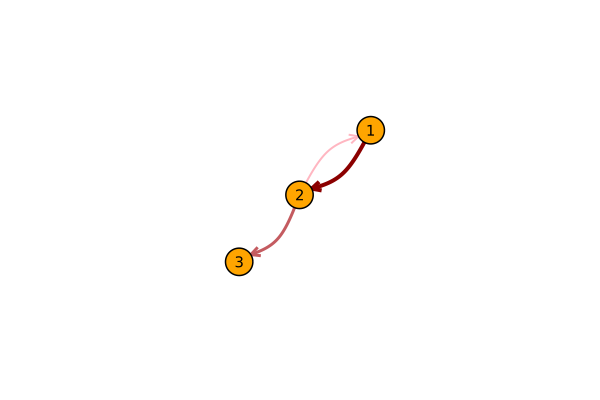

In [59]:
graph = SimpleDiGraph(3)
add_edge!(graph, 1,2)
add_edge!(graph, 2,1)
add_edge!(graph, 2,3)

metagraph = MetaDiGraph(graph)

set_prop!(metagraph, Edge(1,2), :weight, 4.0)
set_prop!(metagraph, Edge(2,1), :weight, 2.0)
set_prop!(metagraph, Edge(2,3), :weight, 3.0)

set_prop!(metagraph, 1, :name, "1")
set_prop!(metagraph, 2, :name, "2")
set_prop!(metagraph, 3, :name, "3")

graphplot(graph, nodesize=0.2, nodeshape=:circle,
    fontsize=10,
    edge_width=(s,d,w) -> get_prop(metagraph, Edge(s,d), :weight),
    line_z=reshape([4.; 2.; 3], 1, :),
    arrow=true,
    nodestrokewidth=1.5,
    nodecolor=:orange,
    edgecolor=:reds,
    curvature_scalar=0.1,
    names=[get_prop(metagraph,n,:name) for n in 1:size(metagraph)[1]],
    self_edge_size=1.0,
    axis_buffer=0.9
    )

In [5]:
phi(a::Number) = (exp(2*a)-1)/(exp(2*a)+1)

phi (generic function with 1 method)

In [ ]:
function additive_noise!(du,u,p,t)
    σ = p[length(p)] #make sure ϕ is the last value in the parameter array
    for i = 1:length(u)
        #This value multiplies a random number drawn from N(0, dt) i.e. noise then scales with sampling rate and effective sd of noise will be e.g. 0.1*dt
        du[i] = σ 
    end
end

In [ ]:
function no_input!(du,u,p,t)
    s,g,b,σ = p
    
    for i=1:length(u)
        du[i] = -u[i] + s*phi(u[i]) + g*(sum(W[i,:].*u))
    end
end

In [ ]:
function w_input!(du,u,p,t)
    s,g,b,σ = p
     
    for i=1:length(u)
        du[i] = -u[i] + s*phi(u[i]) + g*(sum(W[i,:].*u)) + b*I[i](t)
    end
end

In [62]:
using Interpolations

In [63]:
num_blocks = 4
on_len = 10
off_len = 10
stim = repeat([repeat([0.0], Int(off_len)); repeat([1.0], Int(on_len)); repeat([0.0], Int(off_len));], Int(num_blocks))
Tmax = length(stim)
nostim = repeat([0.0], Tmax)
ts = 1:1:Tmax
stim_node = 1
I = Array{Interpolations.FilledExtrapolation}(undef, 3)
for i=1:num_nodes
    if i==stim_node
        I[i] = LinearInterpolation(ts, stim, extrapolation_bc = 0)
    else
        I[i] = LinearInterpolation(ts, nostim, extrapolation_bc = 0)
    end
end

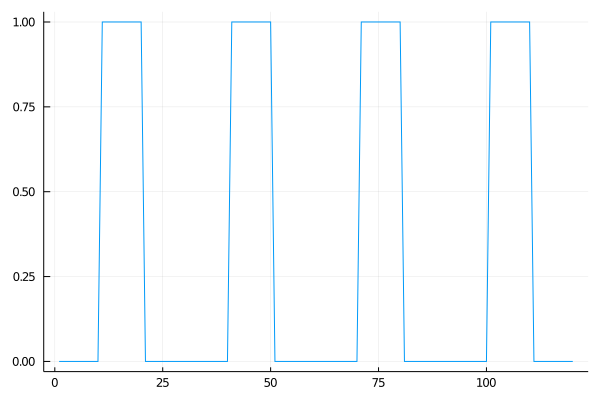

In [65]:
plot(stim, legend=false)

In [ ]:
u0 = repeat([0.0], num_nodes)
Tmax = 100.0
tspan = (0,Tmax)
dt = 0.25
# s,g,b,σ = p
p = [0.3, 0.7, 0.0, 0.01]

prob_noinput = SDEProblem(no_input!,additive_noise!,u0,tspan,p)
# sol = solve(prob_sde, dt=dt, adaptive=false)
# plot(sol)

Note: If you don't turn off adaptive step size then the number of solved points will not be Tmax/dt. It will be determined as detailed [here](https://diffeq.sciml.ai/stable/basics/common_solver_opts/#Basic-Stepsize-Control)

In [ ]:
ensembleprob = EnsembleProblem(prob_sde)
data = solve(ensembleprob, SOSRI(), trajectories=25, dt=dt, adaptive=false)
plot(EnsembleSummary(data))

In [ ]:
Turing.setadbackend(:forwarddiff)
@model function fit_noinput(data, prob)
    s ~ truncated(Normal(1.0,1.0),0.0,3.0)
    g ~ truncated(Normal(1.0,1.0),0.0,3.0)
    b = 0.0
    σ ~ truncated(Normal(0.0,1.0),-3.0,3.0)
    obs_noise ~ InverseGamma(2,3)
    
    p = [s,g,b,σ]

    prob = remake(prob, p=p)
    predicted = solve(prob, SOSRI(), dt=dt, adaptive=false)

    if predicted.retcode != :Success
        Turing.acclogp!(_varinfo, -Inf)
    end
    for j in 1:length(data) #number of ensemble iterations
        for i = 1:length(predicted) #number of time points
            data[j][i] ~ MvNormal(predicted[i], obs_noise) #generate 3 points at a time for each node
        end
    end
end;

In [ ]:
model = fit_noinput(dat_noinput, prob_sde)

In [ ]:
@time q_noinput = vi(model, ADVI(10, 2000))

In [ ]:
#The vector has the same ordering as the model
samples = rand(q_noinput, 10000)

p1 = histogram(samples[1, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[1, :], label = "σ (ADVI)", color = :blue, linewidth = 2)
# vline!([var(x)], label = "σ (data)", color = :black)
vline!([mean(samples[1, :])], color = :blue, label ="")

p2 = histogram(samples[2, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[2, :], label = "ϕ (ADVI)", color = :blue, linewidth = 2)
vline!([p[4]], label = "ϕ (data)", color = :black)
vline!([mean(samples[2, :])], color = :blue, label ="")

plot(p1, p2, p3, p4, layout=(4,1), size=(500, 700))

Correlation between parameters?

Likelihood surface?

In [ ]:
# @time chain = sample(model, NUTS(), 500)
# plot(chain)
